In [73]:
MAX_LEN = 26
LR = 0.0001
BATCH_SIZE = 512

import os
import time
import json
from tqdm import tqdm
import numpy as np
import pandas as pd

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.callbacks.progress import ProgressBar
from pytorch_lightning.loggers import CSVLogger

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve, matthews_corrcoef, plot_confusion_matrix, average_precision_score, auc
from collections import defaultdict
import seaborn as sns

In [2]:
class CNNRegression(pl.LightningModule):
    def __init__(self):
        super(CNNRegression, self).__init__()
        self.out_predictions = []
        self.forward_flag = 0
        
        self.conv2d_block = nn.Sequential(
            nn.Conv2d(2, 256, (4, 9)),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout2d(0.2),
        )
        
        self.conv1d_block = nn.Sequential(
            nn.Conv1d(256, 128, 9),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Conv1d(128, 64, 3),
            nn.ReLU(),
            nn.BatchNorm1d(64),
        )
            
        self.lin_block = nn.Sequential(
            nn.Linear(64 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.conv2d_block(x)
        x = self.conv1d_block(torch.squeeze(x))
        x = x.view(x.size(0), -1)
        x = self.lin_block(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        loss = F.mse_loss(torch.squeeze(self(x)), y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LR)
            
    def validation_step(self, batch, batch_idx):
        x, y = batch
        val_loss = F.mse_loss(torch.squeeze(self(x)), y)
        self.log('val_loss', val_loss)
        return val_loss
            
    def test_step(self, batch, batch_idx):
        x, y = batch
        test_out = self(x)
        self.out_predictions.append(test_out)
        test_loss = F.mse_loss(torch.squeeze(test_out), y)
        self.log('test_loss', test_loss)
        return test_loss

In [3]:
def encode(seq, max_len):
    nucl_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    mat = np.zeros((4, max_len), dtype=int)
    
    for i, nucl in enumerate(seq):
        mat[nucl_dict[nucl]][i] = 1

    return mat

def encode_pair(seq1, seq2, max_len):
    enc1 = encode(seq1, max_len)
    enc2 = encode(seq2, max_len)
    return np.array([enc1, enc2])

In [10]:
all_temps_df = pd.read_csv('test_set_other_temperatures.csv')

In [11]:
all_temps_df

,Seq1,Seq2,Yield_37C,Yield_42C,Yield_47C,Yield_52C,Yield_62C
0,CGTACGTGAATCGCCGGATC,CGTTCGTGATACGCCGGATC,0.003057,0.002316,0.001621,0.001056,0.000385
1,AACCTCCATATTTGAACTACGTCC,AACCTCCACACTTGAACTACGTCC,0.001860,0.000940,0.000491,0.000268,0.000096
2,CCACACCGCGGATCAGGTGAATCG,CCACACCGGGATCAGGTGAATCG,0.000610,0.000330,0.000188,0.000117,0.000070
3,AAAGAAGTGGTACTAGTGT,TAAGGAGAGATATCAGCGA,0.000013,0.000013,0.000013,0.000013,0.000012
4,CATCTTCCAAGATGTTACCACA,CATTTTCCACGATCTTTCCACG,0.000021,0.000027,0.000035,0.000042,0.000052
...,...,...,...,...,...,...,...
255696,GCGGAAATCGTCACTATTATTAGCAT,ATGCTAATAACAGTGACGATTTCTGG,0.999917,0.999627,0.998255,0.991691,0.840384
255697,AGCAAGGCACAGGACTTAGTACCAAA,TTTGGTACTAAGTCCTGTGCCGCT,0.999994,0.999968,0.999826,0.999075,0.976711
255698,CAGGCTGAGACCTAACTCTTTAGCC,GGCTAAAAGGTTAGGTCTCAGCCTG,0.999879,0.999543,0.998261,0.993277,0.899956
255699,GAATGCAGAGTTCGATGTCGGT,ACCAGTACACATCGAACTCTGCATTC,0.999919,0.999686,0.998820,0.995678,0.948229


In [53]:
y_test_37 = all_temps_df['Yield_37C'].values
y_test_42 = all_temps_df['Yield_42C'].values
y_test_47 = all_temps_df['Yield_47C'].values
y_test_52 = all_temss_df['Yield_52C'].values
y_test_62 = all_temps_df['Yield_62C'].values

y_test_37 = y_test_37 * 100
y_test_42 = y_test_42 * 100
y_test_47 = y_test_47 * 100
y_test_52 = y_test_52 * 100
y_test_62 = y_test_62 * 100

In [4]:
train = json.load(open('../splits/train.json'))
val = json.load(open('../splits/val.json'))
test = json.load(open('../splits/test.json'))
y_train = np.load('../splits/y_train.npy')
y_val = np.load('../splits/y_val.npy')
y_test = np.load('../splits/y_test.npy')

In [5]:
y_train = y_train * 100
y_val = y_val * 100
y_test = y_test * 100

X_train = [encode_pair(item[0], item[1], MAX_LEN) for item in train]
X_val = [encode_pair(item[0], item[1], MAX_LEN) for item in val]
X_test = [encode_pair(item[0], item[1], MAX_LEN) for item in test]

X_train = np.array(X_train, dtype=np.dtype('d'))
X_val = np.array(X_val, dtype=np.dtype('d'))
X_test = np.array(X_test, dtype=np.dtype('d'))

In [6]:
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.double)

In [13]:
train_dataloader = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val)), batch_size=BATCH_SIZE, num_workers=0)
test_dataloader = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)), batch_size=BATCH_SIZE, num_workers=0)

In [54]:
test_dataloader_37 = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test_37)), batch_size=BATCH_SIZE, num_workers=0)
test_dataloader_42 = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test_42)), batch_size=BATCH_SIZE, num_workers=0)
test_dataloader_47 = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test_47)), batch_size=BATCH_SIZE, num_workers=0)
test_dataloader_52 = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test_52)), batch_size=BATCH_SIZE, num_workers=0)
test_dataloader_62 = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test_62)), batch_size=BATCH_SIZE, num_workers=0)

In [102]:
loader = test_dataloader_62
labels = y_test_62

model_chkp = CNNRegression.load_from_checkpoint('...')
model_chkp.eval()

trainer_chkp = pl.Trainer(gpus=[0])
trainer_chkp.test(model_chkp, test_dataloaders=loader)

predictions = [[pred.item() for pred in preds] for preds in model_chkp.out_predictions]
preds_flat = [j for sub in predictions for j in sub]
predictions_np = np.array(preds_flat)
predictions_labels = [1 if x > 20 else 0 for x in predictions_np]
true_labels = [1 if x > 20 else 0 for x in labels]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(418.6368, device='cuda:0', dtype=torch.float32)}
--------------------------------------------------------------------------------


In [103]:
cf_matrix = confusion_matrix(true_labels, predictions_labels)

<AxesSubplot:>

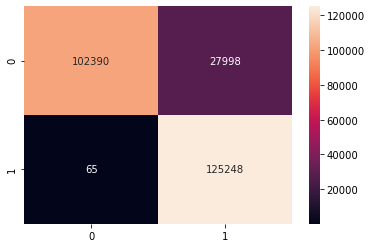

In [104]:
sns.heatmap(cf_matrix, annot=True, fmt='g')

<AxesSubplot:>

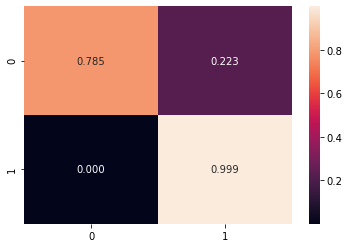

In [105]:
sns.heatmap(cf_matrix / cf_matrix.astype(np.float).sum(axis=1), annot=True, fmt='.3f')

In [106]:
matthews_corrcoef(true_labels, predictions_labels)  

0.8005504014472546

In [107]:
precision_recall_fscore_support(true_labels, predictions_labels, average=None)

(array([0.99936558, 0.81730029]),
 array([0.78527165, 0.9994813 ]),
 array([0.87947673, 0.89925653]),
 array([130388, 125313], dtype=int64))

In [108]:
fpr, tpr, thresholds = roc_curve(true_labels, predictions_labels)
auc(fpr, tpr)

0.8923764747965716

In [109]:
average_precision_score(true_labels, predictions_labels)

0.817130556958785